<a href="https://colab.research.google.com/gist/u7693/70ea40b0fed2b85e116ed301fb30c65e/100knock2021-chapter06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2021-06-28 23:42:45--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip.4’

NewsAggregatorDatas 100%[===================>]  27.87M  10.6MB/s    in 2.6s    

2021-06-28 23:42:48 (10.6 MB/s) - ‘NewsAggregatorDataset.zip.4’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 2pageSessions.csv       
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         A

  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


## knock50

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('./newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=0, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=0, stratify=valid_test['CATEGORY'])

train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

## knock51

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_valid = df[:len(train) + len(valid)]
test = df[len(train) + len(valid):]

vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

x_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])
x_test = vec_tfidf.transform(test['TITLE'])

x_train_valid = pd.DataFrame(x_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
x_test = pd.DataFrame(x_test.toarray(), columns=vec_tfidf.get_feature_names())

x_train = x_train_valid[:len(train)]
x_valid = x_train_valid[len(train):]

x_train.to_csv('./x_train.txt', sep='\t', index=False)
x_valid.to_csv('./x_valid.txt', sep='\t', index=False)
x_test.to_csv('./x_test.txt', sep='\t', index=False)

## knock52

In [4]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, max_iter=10000)
lr.fit(x_train, train['CATEGORY'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## knock53

In [5]:
import numpy as np

def eval_lr(x):
    return [np.max(lr.predict_proba(x), axis=1), lr.predict(x)]

train_pred = eval_lr(x_train)
test_pred = eval_lr(x_test)

## knock54

In [6]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])
print(f'学習データ: {train_accuracy}')
print(f'評価データ: {test_accuracy}')

学習データ: 0.5854572713643178
評価データ: 0.4070464767616192


## knock55

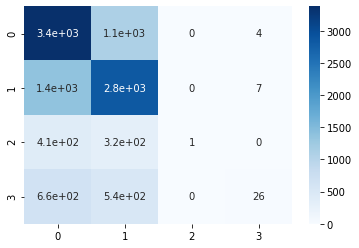

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    confusion_matrix(train['CATEGORY'], train_pred[1]),
    annot=True,
    cmap='Blues'
)
plt.show()

## knock56

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = test['CATEGORY']
y_pred = test_pred[1]

# 適合率
precision = precision_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm']) 
precision = np.append(precision, precision_score(y_true, y_pred, average='micro')) 
precision = np.append(precision, precision_score(y_true, y_pred, average='macro')) 

# 再現率
recall = recall_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

# F1スコア
f1 = f1_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

scores = pd.DataFrame(
    {'適合率': precision, '再現率': recall, 'F1スコア': f1},
    index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均']
)
print(scores)

             適合率       再現率     F1スコア
b       0.456067  0.544093  0.496206
e       0.351792  0.492027  0.410256
t       0.000000  0.000000  0.000000
m       0.000000  0.000000  0.000000
マイクロ平均  0.407046  0.407046  0.407046
マクロ平均   0.201965  0.259030  0.226616


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## knock57

In [9]:
features = x_train.columns.values
index = [i for i in range(1, 11)]

for c, coef in zip(lr.classes_, lr.coef_):
    print(f'Category: {c}')
    best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['高'], index=index).T
    worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['低'], index=index).T
    display(pd.concat([best10, worst10], axis=0))

Category: b


,1,2,3,4,5,6,7,8,9,10
高,minister,selling,dips,single,report,death of,may,ads,cable,series
低,hbo,january,yahoo,out of,own,asian,update china,beyond,year high,asian stocks


Category: e


,1,2,3,4,5,6,7,8,9,10
高,yuan,boe,time for,cast,arrest,fourth,stay,currency,racist,house
低,debate,billionaire,pill,on ukraine,cobain,warn,claim,leads,shares fall,today


Category: m


,1,2,3,4,5,6,7,8,9,10
高,size,good,slump,death,phone,sector,model,cap,name,the most
低,home,now,she,air,us,he,year,voice,barclays,may


Category: t


,1,2,3,4,5,6,7,8,9,10
高,girlfriend,set to,celebrity,prompt,release,ny,people,effects,gay,finally
低,out,mother,tour,costs,boe,forex,key,day,in the,cars


## knock58

In [10]:
from tqdm import tqdm

result = []

for C in tqdm(np.logspace(-5, 4, 10, base=10)):
    lr = LogisticRegression(random_state=0, max_iter=10000, C=C)
    lr.fit(x_train, train['CATEGORY'])

    train_accuracy = accuracy_score(train['CATEGORY'], eval_lr(x_train)[1])
    valid_accuracy = accuracy_score(valid['CATEGORY'], eval_lr(x_valid)[1])
    test_accuracy = accuracy_score(test['CATEGORY'], eval_lr(x_test)[1])

    result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 10/10 [35:54<00:00, 215.44s/it]


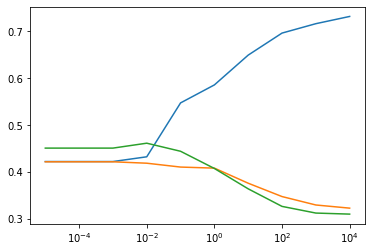

In [11]:
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.xscale ('log')
plt.show()

## knock59

In [12]:
!pip install optuna

In [13]:
import optuna

def objective_lr(trial):
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    C = trial.suggest_loguniform('C', 1e-4, 1e4)

    lr = LogisticRegression(random_state=0, 
                            max_iter=10000, 
                            penalty='elasticnet', 
                            solver='saga', 
                            l1_ratio=l1_ratio, 
                            C=C)
    lr.fit(x_train, train['CATEGORY'])
    valid_pred = eval_lr(x_valid)
    valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])    
    return valid_accuracy 

study = optuna.create_study(direction='maximize')
study.optimize(objective_lr, timeout=3600)
trial = study.best_trial

[I 2021-06-29 01:00:03,085] A new study created in memory with name: no-name-f58545be-f697-436d-b716-87dc0dc6f57b
[I 2021-06-29 02:09:03,165] Trial 0 finished with value: 0.32233883058470764 and parameters: {'l1_ratio': 0.9835073013776175, 'C': 70.52670871864913}. Best is trial 0 with value: 0.32233883058470764.


In [14]:
l1_ratio = trial.params['l1_ratio']
C = trial.params['C']

lr = LogisticRegression(random_state=0, 
                        max_iter=10000, 
                        penalty='elasticnet', 
                        solver='saga', 
                        l1_ratio=l1_ratio, 
                        C=C)
lr.fit(x_train, train['CATEGORY'])

train_accuracy = accuracy_score(train['CATEGORY'], eval_lr(x_train)[1]) 
valid_accuracy = accuracy_score(valid['CATEGORY'], eval_lr(x_valid)[1]) 
test_accuracy = accuracy_score(test['CATEGORY'], eval_lr(x_test)[1]) 

print(f'学習データ: {train_accuracy:.3f}')
print(f'検証データ: {valid_accuracy:.3f}')
print(f'評価データ: {test_accuracy:.3f}')

学習データ: 0.715
検証データ: 0.323
評価データ: 0.309
